In [2]:
# source from https://github.com/snji-khjuria/GloveModel
    
#essential imports
import tensorflow as tf
import  os

In [3]:
#configuration variables
fileLocation        = "./corpus"
vocab_size          = 100000
min_occurence       = 1
scaling_factor      = 3/4.0
cooccurence_cap     = 100
batch_size          = 2
learning_rate       = 0.05
embedding_size      = 10
left_context_size   = 2
right_context_size  = 2
words               = None
word_to_id          = None
#cooccurence_matrix[w1, w2] = float
cooccurence_matrix  = None
embeddings          = None
epoch_loss_print    = 10
epoch_tsne_print    = 10
log_dir             = "./logs"

In [16]:
#utility to read the corpus
def readCorpus(filename):
#    docs = [
#        "With Windows 10 Home - get the best combination of Windows features you know and new improvements you'll love",
#        "NVIDIA Geforce for High Graphics Performance",
#        "15.6 inch HD LED Backlit Anti-glare TN Display"
#    ]
    docs = [
        "roger roger roger anna anna roger roger",
        "roger roger roger anna anna roger roger"
    ]
    for line in docs: # open(filename):
        line = line.strip()
        yield line.lower().split()

#get the left context
def get_left_context(region, i, left_size):
    start_index = i-left_size
    if start_index<0:
        start_index=0
    left_context = region[start_index:i]
    left_more = ['null_word']*(left_size-len(left_context))
    left_more.extend(left_context)
    return left_more

#get the right context window
def get_right_context(region, i, right_size):
    end_index = i+right_size+1
    total_region = len(region)
    if end_index>total_region:
        end_index=total_region
    right_context = region[i+1:end_index]
    right_context.extend(['null_word']*(right_size-len(right_context)))
    return right_context

#get the window
def window(region, left_size=3, right_size=3):
    total_region = len(region)
    for i, word in enumerate(region):
        left_context = get_left_context(region, i, left_size)
        right_context = get_right_context(region, i, right_size)
        yield (left_context, word, right_context)

In [17]:
from collections import Counter, defaultdict
def fit_to_corpus(corpus, vocab_size, min_occurences, left_size, right_size):
    words_count = Counter()
    #provides value for non-existent key
    cooccurence_counts = defaultdict(float)
    for region in corpus:
        words_count.update(region)
        #add 1/distance from the position of centralized context word
        for l_context, word, r_context in window(region, left_size, right_size):
            for i, context_word in enumerate(l_context[::-1]):
                cooccurence_counts[(word, context_word)] += 1/(i+1)
            for i, context_word in enumerate(r_context):
                cooccurence_counts[(word, context_word)] += 1/(i+1)
    words = [word for word, count in words_count.most_common(vocab_size) if count>=min_occurences]
    word_to_id = {word:i for i, word in enumerate(words)}
    cooccurence_matrix = {
                        (word_to_id[words[0]], word_to_id[words[1]]):count
                        for words, count in cooccurence_counts.items()
                         if words[0] in word_to_id and words[1] in word_to_id
                        }
    return words, word_to_id, cooccurence_matrix

In [18]:
#get the corpus
corpus                                = readCorpus(fileLocation)
#get words, word_to_id and cooccurence matrix by fitting it to corpus
#we have words, wordstoid and possible cooccurence matrix for the words
words, word_to_id, cooccurence_matrix = fit_to_corpus(corpus, vocab_size, min_occurence, left_context_size, right_context_size)

In [19]:
print(cooccurence_matrix)

{(0, 1): 8.0, (1, 0): 8.0, (0, 0): 14.0, (1, 1): 4.0}


In [20]:
focal_input         = tf.placeholder(tf.int32, shape=[batch_size], name="focal_words")
context_input       = tf.placeholder(tf.int32, shape=[batch_size], name="context_words")
cooccurence_count   = tf.placeholder(tf.float32, shape=[batch_size], name="cooccurence_count")
# epsilon          
#full embedding size variables
focal_embeddings    = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="focal_embeddings")
context_embeddings  = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="context_embeddings")
focal_biases        = tf.Variable(tf.random_uniform([vocab_size], -1.0, 1.0), name="focal_biases")
context_biases      = tf.Variable(tf.random_uniform([vocab_size], -1.0, 1.0), name="context_biases")
#embeddings lookup
focal_embedding     = tf.nn.embedding_lookup([focal_embeddings], focal_input)
context_embedding   = tf.nn.embedding_lookup([context_embeddings], context_input)
focal_bias          = tf.nn.embedding_lookup([focal_biases], focal_input)
context_bias        = tf.nn.embedding_lookup([context_biases], context_input)
product             = tf.multiply(focal_embedding, context_embedding)
embedding_product   = tf.reduce_sum(tf.multiply(focal_embedding, context_embedding), 1)
cooccurence_epsilon = cooccurence_count+1e-10
log_cooccurences    = tf.log(cooccurence_epsilon)
distance_expr       = tf.square(tf.add_n([
                        embedding_product,
                        focal_bias,
                        context_bias,
                        tf.negative(log_cooccurences)]))
count_max           = tf.constant([cooccurence_cap], dtype=tf.float32, name="max_cooccurence_count")
scaling_factor_input      = tf.constant([scaling_factor], dtype=tf.float32, name="scaling_factor")
weighting_factor    = tf.minimum(1.0, tf.pow(tf.div(cooccurence_count, count_max), scaling_factor_input))
single_losses       = tf.multiply(weighting_factor, distance_expr)
total_loss          = tf.reduce_sum(single_losses)
optimizer           = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
combined_embeddings = tf.add(focal_embeddings, context_embeddings, name="combined_embeddings")


In [21]:
def batchify(batch_size, *sequences):
    for i in range(0, len(sequences[0]), batch_size):
        yield tuple(sequence[i:i+batch_size] for sequence in sequences)

def prepare_batches():
    #get cooccurence matrix as list of elements and return each list as batch
    cooccurrences = [(word_ids[0], word_ids[1], count) for word_ids, count in cooccurence_matrix.items()]
    i_indices, j_indices, counts = zip(*cooccurrences)
    return list(batchify(batch_size, i_indices, j_indices, counts))

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_with_labels(low_dim_embs, labels, path, size):
    figure = plt.figure(figsize=size)  # in inches
    for i, label in enumerate(labels):
        #for each label get its x and y position.
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        #text of annotation, xyposition, place label, coordinate system, 
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right',
                     va='bottom')
    if path is not None:
        figure.savefig(path)
        plt.close(figure)

def generate_tsne(path, size=(10, 10), word_count=1000, embeddings=None):
    #get tsne representation
    tsne         = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    #get the tsne transformation for each embedding
    low_dim_embs = tsne.fit_transform(embeddings[:word_count, :])
    #get label to assign for each point in embedding space
    labels       = words[:word_count]
    return plot_with_labels(low_dim_embs, labels, path, size)


In [23]:
def train(num_epochs):
    #get the batches
    total_steps=0
    batches = prepare_batches()
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for epoch in range(num_epochs):
            for batch_index, batch in enumerate(batches):
                i_s, j_s, counts = batch
                feed_dict = {focal_input:i_s, context_input:j_s, cooccurence_count:counts}
                sess.run([optimizer], feed_dict=feed_dict)
                total_steps+=1
            if epoch%epoch_loss_print==0:
                loss = sess.run([total_loss], feed_dict)
                print("Loss is " + str(loss))
            if epoch%epoch_tsne_print==0:
                embeddings      = combined_embeddings.eval()
                outputLocation  = ""
                output_path = os.path.join(log_dir, "epoch{:03d}.jpeg".format(epoch))
                generate_tsne(output_path, embeddings=embeddings)
        embeddings = combined_embeddings.eval()
    return embeddings

Loss is [3.5839138]


FileNotFoundError: [Errno 2] No such file or directory: './logs/epoch000.jpeg'

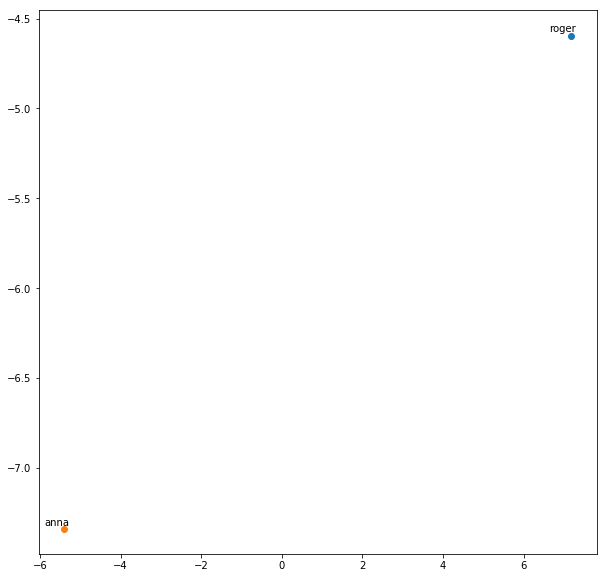

In [24]:
embeddings = train(200)
# print(embeddings)

In [179]:
output_path = os.path.join(log_dir, "final_embeddings.jpeg")
generate_tsne(output_path, embeddings=embeddings)
print("Image generated")

Image generated


In [ ]:
#understand how the full code works with functions written in matrix
#refactor for printing and the corpus fully built up.

In [ ]:
#plotting the t-SNE section